2025-07-23 21:51:41.394565: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-23 21:51:41.395424: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-23 21:51:41.399243: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-23 21:51:41.408616: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753307501.422787   55059 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753307501.42

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Confusion Matrix:
[[9340  415]
 [ 160   85]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      9755
           1       0.17      0.35      0.23       245

    accuracy                           0.94     10000
   macro avg       0.58      0.65      0.60     10000
weighted avg       0.96      0.94      0.95     10000

ROC AUC Score: 0.7680339752507872


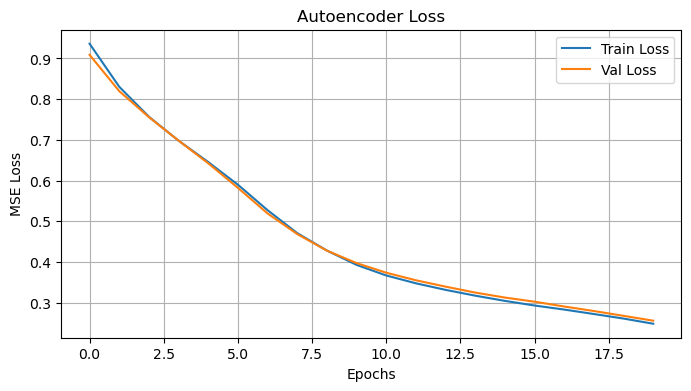

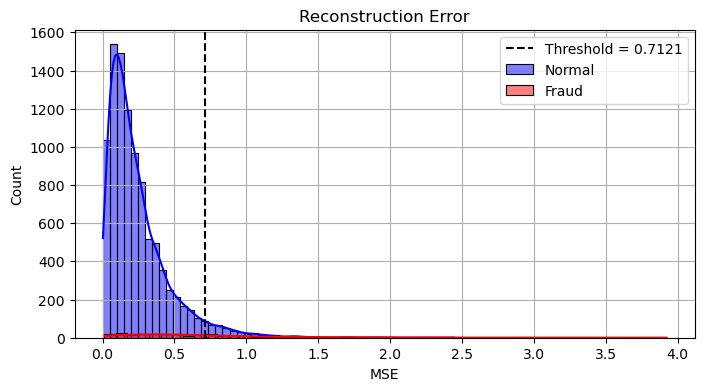

In [4]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# ----- 1. Generate Synthetic Fraud Dataset -----
X, y = make_classification(n_samples=10000, n_features=10, 
                           n_informative=6, weights=[0.98], random_state=1)

df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
df['is_fraud'] = y

# ----- 2. Preprocessing -----
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ----- 3. Split Data -----
# Train only on normal (non-fraud) data
X_train = X_scaled[y == 0]
X_test = X_scaled
y_test = y

# ----- 4. Build Autoencoder -----
input_dim = X_train.shape[1]
encoding_dim = 5  # Bottleneck size

input_layer = Input(shape=(input_dim,))
encoder = Dense(8, activation="relu")(input_layer)
encoder = Dense(encoding_dim, activation="relu")(encoder)
decoder = Dense(8, activation="relu")(encoder)
decoder = Dense(input_dim, activation="linear")(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer="adam", loss="mse")

# ----- 5. Train Autoencoder -----
history = autoencoder.fit(X_train, X_train,
                          epochs=20,
                          batch_size=128,
                          shuffle=True,
                          validation_split=0.1,
                          verbose=0)

# ----- 6. Reconstruction Error -----
X_test_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

# Threshold: Use quantile (e.g., 95%) or manual
threshold = np.percentile(mse, 95)
y_pred = (mse > threshold).astype(int)

# ----- 7. Evaluation -----
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, mse))

# ----- 8. Visualization -----
# a. Loss Curve
plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Autoencoder Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid()
plt.show()

# b. Error Distribution
plt.figure(figsize=(8, 4))
sns.histplot(mse[y == 0], color="blue", label="Normal", bins=50, kde=True)
sns.histplot(mse[y == 1], color="red", label="Fraud", bins=50, kde=True)
plt.axvline(threshold, color="black", linestyle="--", label=f"Threshold = {threshold:.4f}")
plt.title("Reconstruction Error")
plt.xlabel("MSE")
plt.legend()
plt.grid()
plt.show()
